In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import csv
from sklearn.feature_extraction.text import CountVectorizer

In [2]:
data = pd.read_csv('movie_plots.csv')

In [3]:
data.head()

,Release Year,Title,Origin/Ethnicity,Director,Cast,Genre,Wiki Page,Plot
0,1901,Kansas Saloon Smashers,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Kansas_Saloon_Sm...,"A bartender is working at a saloon, serving dr..."
1,1901,Love by the Light of the Moon,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Love_by_the_Ligh...,"The moon, painted with a smiling face hangs ov..."
2,1901,The Martyred Presidents,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/The_Martyred_Pre...,"The film, just over a minute long, is composed..."
3,1901,"Terrible Teddy, the Grizzly King",American,Unknown,NaN,unknown,"https://en.wikipedia.org/wiki/Terrible_Teddy,_...",Lasting just 61 seconds and consisting of two ...
4,1902,Jack and the Beanstalk,American,"George S. Fleming, Edwin S. Porter",NaN,unknown,https://en.wikipedia.org/wiki/Jack_and_the_Bea...,The earliest known adaptation of the classic f...


In [4]:
len(data)

34886

Let's remove one movie so that we can use it as a user input to test the model at the end of the notebook.

In [5]:
data = data[data['Title'] != 'The Dark Knight']

In [6]:
data.columns

Index(['Release Year', 'Title', 'Origin/Ethnicity', 'Director', 'Cast',
       'Genre', 'Wiki Page', 'Plot'],
      dtype='object')

In [7]:
pd.set_option('display.max_rows', None)

In [8]:
data['Genre'].value_counts().head()

unknown    6083
drama      5964
comedy     4379
horror     1167
action     1098
Name: Genre, dtype: int64

In [9]:
df = data.copy()

Let's work with a smaller data set so that it becomes less computationally heavy for the computer later when when we try to create predictions.

In [10]:
df = df.sample(5000)

In [11]:
df.head()

,Release Year,Title,Origin/Ethnicity,Director,Cast,Genre,Wiki Page,Plot
4183,1946,Beware,American,Bud Pollard,"Louis Jordan, Frank L. Wilson",drama,https://en.wikipedia.org/wiki/Beware_(film),"Ware College is a small Black college in Ware,..."
5231,1950,The Skipper Surprised His Wife,American,Elliott Nugent,"Robert Walker, Joan Leslie",comedy,https://en.wikipedia.org/wiki/The_Skipper_Surp...,"The skipper, Cmdr. William Lattimer (Robert Wa..."
15100,2006,Two Weeks,American,Steve Stockman,"Sally Field, Ben Chaplin",comedy-drama,https://en.wikipedia.org/wiki/Two_Weeks_(2006_...,Four siblings return home to their mother's ho...
29556,1978,Ilamai Oonjal Aadukirathu,Tamil,C. V. Sridhar,"Kamal Haasan, Rajinikanth, Jayachitra, Sripriya",unknown,https://en.wikipedia.org/wiki/Ilamai_Oonjal_Aa...,"Prabhu, an orphan, is brought up by his friend..."
9024,1974,The Conversation,American,Francis Ford Coppola,"Gene Hackman, John Cazale, Cindy Williams, Fre...",unknown,https://en.wikipedia.org/wiki/The_Conversation,Harry Caul is a surveillance expert who runs h...


Let's drop any ambiguous genre's from this data frame, and the rename plot to story to avoid any confusion with the function called 'plot'

In [12]:
index_names = df[(df['Genre'] == 'unknown') | (df['Genre'] == ' usa')
                | (df['Genre'] == ' usa, can') | (df['Genre'] == '[140]')
                | (df['Genre'] == '[144]') | (df['Genre'] == '-')
                | (df['Genre'] == '16 mm film') | (df['Genre'] == ' ')
                | (df['Genre'] == ' ')].index
df.drop(index_names, inplace = True)

In [13]:
df.rename(columns = {'Genre': 'genre', 'Plot': 'story'}, inplace=True)

In [14]:
len(df)

4135

Now let's create unique values for each respective genre that exists in the dataframe.

In [15]:
df['category_id'] = df["genre"].factorize()[0]
category_to_id = df[['genre','category_id']].drop_duplicates().sort_values('category_id')
id_to_category = dict(category_to_id[['category_id', 'genre']].values)

In [16]:
id_to_category

{0: 'drama',
 1: 'comedy',
 2: 'comedy-drama',
 3: 'musical',
 4: 'suspense',
 5: 'comedy, mystery',
 6: 'crime comedy',
 7: 'crime',
 8: 'social drama',
 9: 'horror',
 10: 'biopic',
 11: 'family',
 12: 'fantasy / comedy',
 13: 'western',
 14: 'horror, dark fantasy, supernatural horror, action, monster, spy',
 15: 'fantasy',
 16: 'drama, family',
 17: 'crime drama',
 18: 'romance/drama',
 19: 'family drama',
 20: 'action, drama, adventure',
 21: 'musical comedy',
 22: 'action',
 23: 'thriller',
 24: 'serial',
 25: 'drama, social',
 26: 'siddharth narayan, charmme, sada',
 27: 'romantic drama',
 28: 'spy action',
 29: 'romance',
 30: 'romantic comedy',
 31: 'adventure',
 32: 'animation, comedy, fantasy, family',
 33: 'action, sci-fi, comedy, spy, tokusatsu',
 34: 'adventure, animated, comedy',
 35: 'historical',
 36: 'science fiction',
 37: 'war',
 38: 'comedy/drama',
 39: 'comedy, musical',
 40: 'psychological thriller',
 41: 'anime',
 42: 'comedy, fantasy',
 43: 'film noir',
 44: 'act

In [17]:
df.head()

,Release Year,Title,Origin/Ethnicity,Director,Cast,genre,Wiki Page,story,category_id
4183,1946,Beware,American,Bud Pollard,"Louis Jordan, Frank L. Wilson",drama,https://en.wikipedia.org/wiki/Beware_(film),"Ware College is a small Black college in Ware,...",0
5231,1950,The Skipper Surprised His Wife,American,Elliott Nugent,"Robert Walker, Joan Leslie",comedy,https://en.wikipedia.org/wiki/The_Skipper_Surp...,"The skipper, Cmdr. William Lattimer (Robert Wa...",1
15100,2006,Two Weeks,American,Steve Stockman,"Sally Field, Ben Chaplin",comedy-drama,https://en.wikipedia.org/wiki/Two_Weeks_(2006_...,Four siblings return home to their mother's ho...,2
18708,1945,I'll Be Your Sweetheart,British,Val Guest,"Margaret Lockwood, Vic Oliver",musical,https://en.wikipedia.org/wiki/I%27ll_Be_Your_S...,In 1900 Bob Fielding arrives in London from th...,3
11156,1989,Dead Calm,American,Phillip Noyce,"Nicole Kidman, Sam Neill, Billy Zane",suspense,https://en.wikipedia.org/wiki/Dead_Calm_(film),Rae Ingram (Nicole Kidman) is involved in a ca...,4


Let's look at the top genre's here.

In [18]:
genre_size = df.groupby('genre').story.count()
genre_size = genre_size.sort_values(ascending=False).head(30)

In [19]:
genre_size

genre
drama              870
comedy             609
horror             172
action             155
thriller           138
romance            130
western            116
crime               87
romantic comedy     80
adventure           79
crime drama         74
science fiction     61
musical             57
film noir           52
mystery             52
animation           45
war                 42
comedy, drama       34
family              32
sci-fi              32
fantasy             30
animated            30
musical comedy      30
comedy-drama        27
anime               18
romantic drama      18
suspense            16
romance, drama      14
biography           13
social              13
Name: story, dtype: int64

In [20]:
top_df = list(genre_size.head(10).index)
top_df = df.loc[df['genre'].isin(top_df)]
len(top_df)
df = top_df.copy()

category_to_id = df[['genre','category_id']].drop_duplicates().sort_values('category_id')
id_to_category = dict(category_to_id[['category_id', 'genre']].values)

In [21]:
vectorizer = CountVectorizer(tokenizer = lambda x: x.split(','))

genre_dtm = vectorizer.fit_transform(df['genre'])

In [22]:
print("Number of data points:", genre_dtm.shape[0])
print("Number of unique genres:", genre_dtm.shape[1])

Number of data points: 2436
Number of unique genres: 10


In [23]:
genres = vectorizer.get_feature_names()

print("Some genres are:", genres[:10])

Some genres are: ['action', 'adventure', 'comedy', 'crime', 'drama', 'horror', 'romance', 'romantic comedy', 'thriller', 'western']


Now we have our top 10 genres we want to predict on.

In [24]:
freq = genre_dtm.sum(axis=0).A1
result = dict(zip(genres, freq))

In [25]:
genre_df = pd.DataFrame(list(result.items()),columns = ['Genre','Counts']) 

In [26]:
genre_df.head()

,Genre,Counts
0,action,155
1,adventure,79
2,comedy,609
3,crime,87
4,drama,870


In [27]:
genre_df.to_csv('genre_frame.csv', index = True) 

In [28]:
genre_df_sorted = genre_df.sort_values(['Counts'], ascending=False)
genre_counts = genre_df_sorted['Counts'].values

In [29]:
genre_df_sorted.head()

,Genre,Counts
4,drama,870
2,comedy,609
5,horror,172
0,action,155
8,thriller,138


In [30]:
genre_counts

array([870, 609, 172, 155, 138, 130, 116,  87,  80,  79])

In [31]:
genre_quest_count = genre_dtm.sum(axis=1).tolist()

genre_quest_count = [int(j) for i in genre_quest_count for j in i]
print('We have total {} datapoints.'.format(len(genre_quest_count)))
print(genre_quest_count[:10])

We have total 2436 datapoints.
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


<Figure size 1440x720 with 0 Axes>

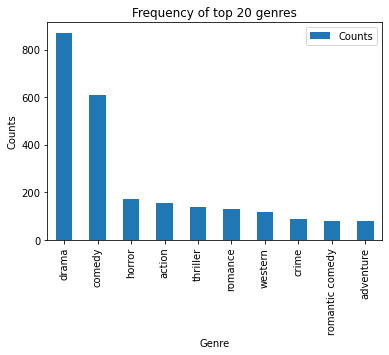

In [32]:
i = np.arange(30)
fig = plt.figure(figsize=(20,10))
genre_df_sorted_top = genre_df_sorted.head(20)
genre_df_sorted_top.plot(x="Genre", y=["Counts"], kind='bar')
plt.title('Frequency of top 20 genres')
plt.xlabel('Genre')
plt.ylabel('Counts')
_=plt.show()

## Quick Data Cleaning & Predictions

In [33]:
df = df.reset_index()

In [34]:
df = df.drop(['index'], axis=1)

In [35]:
df.head()

,Release Year,Title,Origin/Ethnicity,Director,Cast,genre,Wiki Page,story,category_id
0,1946,Beware,American,Bud Pollard,"Louis Jordan, Frank L. Wilson",drama,https://en.wikipedia.org/wiki/Beware_(film),"Ware College is a small Black college in Ware,...",0
1,1950,The Skipper Surprised His Wife,American,Elliott Nugent,"Robert Walker, Joan Leslie",comedy,https://en.wikipedia.org/wiki/The_Skipper_Surp...,"The skipper, Cmdr. William Lattimer (Robert Wa...",1
2,2003,The Statement,British,Norman Jewison,"Michael Caine, Tilda Swinton, Jeremy Northam",drama,https://en.wikipedia.org/wiki/The_Statement_(f...,"Pierre Brossard (Michael Caine), a French Nazi...",0
3,2001,Blow Dry,British,Paddy Breathnach,"Alan Rickman, Natasha Richardson",comedy,https://en.wikipedia.org/wiki/Blow_Dry,Shelley Allen (Natasha Richardson) operates a ...,1
4,2002,Spun,American,Jonas Åkerlund,"Jason Schwartzman, Brittany Murphy, Mickey Rourke",comedy,https://en.wikipedia.org/wiki/Spun,Ross (Jason Schwartzman) is a customer of Spid...,1


In [36]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=1, norm='l2', encoding='latin-1', ngram_range=(1, 2))
features = tfidf.fit_transform(df.story).toarray()
labels = df.category_id
features.shape

(2436, 424615)

In [37]:
from sklearn.model_selection import train_test_split

from sklearn.svm import LinearSVC
model = LinearSVC()
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

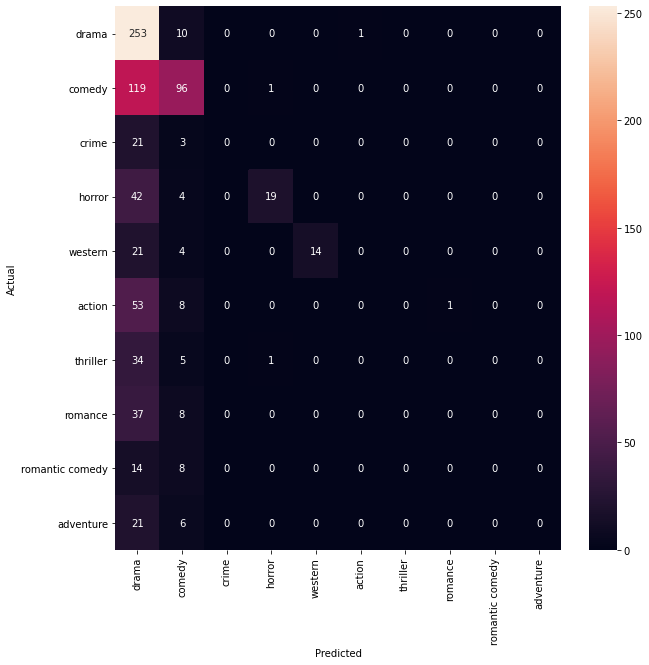

In [38]:
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_to_id.genre.values, yticklabels=category_to_id.genre.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [39]:
X_test

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [48]:
#from sklearn.metrics import accuracy_score
#print("Accuracy: ", accuracy_score(y_test, y_pred))

In [42]:
import pickle
filename = 'top20_genres.pickle'
pickle.dump(model, open(filename, 'wb'))
pickle.dump(tfidf, open("vectorizer_with_sw.pickle", "wb"))
pickle.dump(id_to_category, open('genre_counts_dict_dtm.csv', 'wb'))

In [43]:
loaded_model = pickle.load(open(filename, 'rb'))
loaded_tfidf= pickle.load(open("vectorizer_with_sw.pickle", "rb"))
genre_dict = pickle.load(open("genre_counts_dict_dtm.csv", "rb"))

In [44]:
result = loaded_model.score(X_test, y_test)
print(result)

0.47512437810945274


In [45]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
new_story = 'When the menace known as the Joker wreaks havoc and chaos on the people of Gotham, Batman must accept one of the greatest psychological and physical tests of his ability to fight injustice.'

X_test = loaded_tfidf.transform([new_story])
prediction = loaded_model.predict(X_test)

In [46]:
genre_dict[prediction[0]]

'drama'